Using device: cuda
Loading model: PoloHuggingface/French_grammar_error_corrector
Model loaded.
Loaded 940 sentences. Positive (incorrect) examples: 46


Generating: 100%|██████████| 59/59 [06:00<00:00,  6.11s/it]


Predicted incorrect (1) count: 699

Classification report (all labels):
              precision    recall  f1-score   support

           0     0.9917    0.2673    0.4211       894
           1     0.0629    0.9565    0.1181        46

    accuracy                         0.3011       940
   macro avg     0.5273    0.6119    0.2696       940
weighted avg     0.9463    0.3011    0.4063       940

Positive class (incorrect=1): Precision=0.0629 Recall=0.9565 F1=0.1181


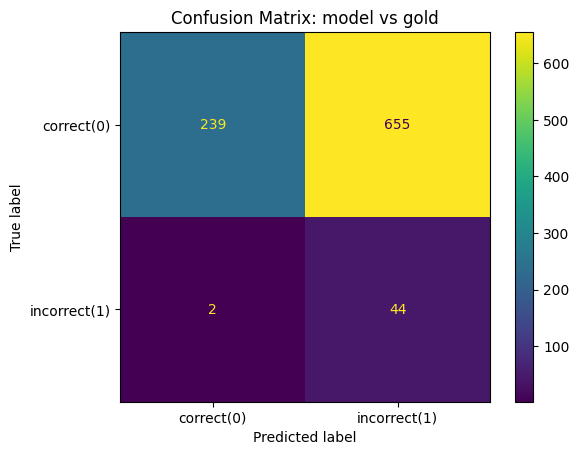

Saved results to /content/french_gector_results.csv

Examples where model changed the sentence (first 10):
GOLD: 0 | PRED: 1
ORIG: Nous vivons dans un monde, où les Inégalités s’étendent à toutes les sphères de la société. La discrimination positive est une politique qui vise à accorder un traitement préférentiel, à certains groupes défavorisés afin de réduire les inégalités. Cette approche, soulève des débats passionnés, quant à son efficacité et à ses implications. Examinons les différents points de vue.
CORR: Nous vivons dans un monde, où les Inégalités s’étendent à toutes les sphères de la société. La discrimination positive est une politique qui vise à accorder un traitement préférentiel, à certains groupes défavorisés afin de réduire les inégalités, soulève des débats passionnés, quant à son efficacité et à ses implications.
------------------------------------------------------------
GOLD: 0 | PRED: 1
ORIG: En effet, dans une perspective de réduction des inégalités : l’instaurat

In [ ]:
!pip install -q transformers torch sentencepiece pandas openpyxl scikit-learn matplotlib tqdm

import os
import re
import math
import torch
import difflib
import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import matplotlib.pyplot as plt

# Configuration
MODEL_NAME = "PoloHuggingface/French_grammar_error_corrector"
DATA_PATH = "/content/data_filtered.xlsx"
BATCH_SIZE = 16
MAX_GEN_TOKENS = 256
IGNORE_PUNCT_ONLY_EDITS = True
SAVE_CSV = "/content/french_gector_results.csv"

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# load model & tokenizer
print("Loading model:", MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
model = model.to(device)
model.eval()
print("Model loaded.")

# load data and build gold labels
# Read Excel file; sentences in 2nd column (index 1), error counts in 3rd column (index 2)
df = pd.read_excel(DATA_PATH, header=1, engine="openpyxl")
if df.shape[1] < 3:
    raise ValueError(f"Expected at least 3 columns in {DATA_PATH} (found {df.shape[1]})")

sentences = df.iloc[:, 1].astype(str).fillna("").tolist()
error_counts = pd.to_numeric(df.iloc[:, 2], errors="coerce").fillna(0).astype(int).tolist()
gold_labels = np.array([1 if c > 0 else 0 for c in error_counts], dtype=int)

print(f"Loaded {len(sentences)} sentences. Positive (incorrect) examples: {gold_labels.sum()}")

# helper functions
_alnum_re = re.compile(r"\w+", flags=re.UNICODE)

def normalize_for_comparison(text):
    """
    Return list of word-like tokens (alphanumeric) to compare ignoring punctuation.
    Lowercases for robust comparison.
    """
    tokens = _alnum_re.findall(text.lower())
    return tokens

def is_punctuation_only_change(orig: str, corrected: str) -> bool:
    """
    Return True if the only changes between orig and corrected are punctuation tokens,
    i.e., the sequences of alphanumeric tokens are identical.
    """
    return normalize_for_comparison(orig) == normalize_for_comparison(corrected)

def model_made_significant_change(orig: str, corrected: str, ignore_punct_only=True) -> bool:
    """
    Decide whether the model actually changed the sentence in a way we consider grammatical.
    If ignore_punct_only is True, changes that only affect punctuation are ignored.
    """
    # Quick exact match
    if orig.strip() == corrected.strip():
        return False
    if ignore_punct_only and is_punctuation_only_change(orig, corrected):
        return False
    # Otherwise consider as a change (could be grammar, spelling, etc.)
    return True

# cell 5: batched inference
def generate_corrections(sent_list, batch_size=BATCH_SIZE, max_length=MAX_GEN_TOKENS, device=device):
    """
    Run the seq2seq model in batches and return decoded strings (corrected outputs).
    """
    corrected = []
    n = len(sent_list)
    for i in tqdm(range(0, n, batch_size), desc="Generating"):
        batch = sent_list[i:i+batch_size]
        # Tokenize with padding (left pad not required for seq2seq, but use padding=True)
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512)
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)

        with torch.no_grad():
            # Use beam search for slightly better corrections; adjust num_beams if desired
            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=max_length,
                num_beams=4,
                early_stopping=True,
                no_repeat_ngram_size=3
            )
        # decode each output
        decoded = [tokenizer.decode(out, skip_special_tokens=True, clean_up_tokenization_spaces=True) for out in outputs]
        corrected.extend(decoded)
    return corrected

# Run generation (this may take time depending on size & device)
corrected_outputs = generate_corrections(sentences, batch_size=BATCH_SIZE)

# derive binary predictions
pred_labels = np.zeros(len(sentences), dtype=int)
for i, (orig, corr) in enumerate(zip(sentences, corrected_outputs)):
    changed = model_made_significant_change(orig, corr, ignore_punct_only=IGNORE_PUNCT_ONLY_EDITS)
    pred_labels[i] = 1 if changed else 0

print("Predicted incorrect (1) count:", int(pred_labels.sum()))

print("\nClassification report (all labels):")
print(classification_report(gold_labels, pred_labels, digits=4, zero_division=0))

# Focused positive-class metrics
p, r, f1, _ = precision_recall_fscore_support(gold_labels, pred_labels, pos_label=1, average='binary', zero_division=0)
print(f"Positive class (incorrect=1): Precision={p:.4f} Recall={r:.4f} F1={f1:.4f}")

# Confusion matrix plot
cm = confusion_matrix(gold_labels, pred_labels, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["correct(0)","incorrect(1)"])
disp.plot()
plt.title("Confusion Matrix: model vs gold")
plt.show()

# Save results
out_df = pd.DataFrame({
    "sentence": sentences,
    "gold_label": gold_labels,
    "pred_label": pred_labels,
    "corrected_output": corrected_outputs
})
out_df.to_csv(SAVE_CSV, index=False, encoding="utf-8")
print(f"Saved results to {SAVE_CSV}")

# Show sample differences
print("\nExamples where model changed the sentence (first 10):")
cnt = 0
for orig, corr, g, p in zip(sentences, corrected_outputs, gold_labels, pred_labels):
    if p == 1:
        print("GOLD:", g, "| PRED:", p)
        print("ORIG:", orig)
        print("CORR:", corr)
        print("-" * 60)
        cnt += 1
        if cnt >= 10:
            break

In [1]:
# Création d'un CSV dans le bon format, CSV contenant exclusivement des phrases correctes

import csv

phrases = [
    "phrase",
    "Le chat dort sur le rebord de la fenêtre.",
    "Nous partirons en randonnée demain matin.",
    "Elle a acheté trois livres à la librairie du coin.",
    "Les enfants jouent au parc après l'école.",
    "Il faut arroser les plantes toutes les semaines.",
    "La conférence commencera à neuf heures précises.",
    "J'aime écouter de la musique en travaillant.",
    "Le train arrive à la gare centrale à midi.",
    "Ils ont préparé un gâteau pour ton anniversaire.",
    "Le ciel est très clair ce soir, on voit les étoiles.",
    "Nous avons terminé le projet avant la date limite.",
    "Peux-tu fermer la fenêtre, il fait froid ici?",
    "Le médecin a recommandé un repos complet pendant une semaine.",
    "Son sourire a illuminé la pièce.",
    "Le restaurant propose des plats végétariens délicieux.",
    "Tous les documents sont classés dans le dossier rouge.",
    "Elle parle couramment trois langues étrangères.",
    "Ce film raconte une histoire vraie et émouvante.",
    "Le marché local vend des fruits frais chaque matin.",
    "Merci de confirmer votre présence par courriel."
]

with open("phrases.csv", mode="w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    for phrase in phrases:
        # Première colonne vide, deuxième colonne avec la phrase
        writer.writerow(["", phrase])

print("Le fichier 'phrases.csv' a été généré avec succès.")


Le fichier 'phrases.csv' a été généré avec succès.


In [11]:
#@title Ajout des étiquettes

import pandas as pd

df = pd.read_csv('/content/phrases.csv')
df['colonne3'] = "0"
df.to_csv('/content/file.csv', index=False)

print(f"Une troisième colonne a été ajoutée et remplie avec '0' pour {len(df)} lignes")
print(f"Colonnes actuelles : {df.columns.tolist()}")

Une troisième colonne a été ajoutée et remplie avec '0' pour 20 lignes
Colonnes actuelles : ['Unnamed: 0', 'phrase', 'colonne3']


In [12]:
#@title CSV to XLSX

import pandas as pd

# Chemin du fichier d'entrée et de sortie
csv_file = '/content/file.csv'
xlsx_file = '/content/file.xlsx'

try:
    # Lire le fichier CSV
    df = pd.read_csv(csv_file)

    # Convertir et sauvegarder en XLSX
    df.to_excel(xlsx_file, index=False, engine='openpyxl')

    print(f"✓ Conversion réussie !")
    print(f"  Fichier source : {csv_file}")
    print(f"  Fichier créé : {xlsx_file}")
    print(f"  Lignes : {len(df)}, Colonnes : {len(df.columns)}")

except FileNotFoundError:
    print(f"✗ Erreur : Le fichier {csv_file} n'existe pas")
except Exception as e:
    print(f"✗ Erreur lors de la conversion : {str(e)}")

✓ Conversion réussie !
  Fichier source : /content/file.csv
  Fichier créé : /content/file.xlsx
  Lignes : 20, Colonnes : 3


Using device: cuda
Loading model: PoloHuggingface/French_grammar_error_corrector


config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

Model loaded.
Loaded 19 sentences. Positive (incorrect) examples: 0



Generating: 100%|██████████| 2/2 [00:06<00:00,  3.08s/it]


Predicted incorrect (1) count: 3

Classification report (all labels):
              precision    recall  f1-score   support

           0     1.0000    0.8421    0.9143        19
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.8421        19
   macro avg     0.5000    0.4211    0.4571        19
weighted avg     1.0000    0.8421    0.9143        19

Positive class (incorrect=1): Precision=0.0000 Recall=0.0000 F1=0.0000


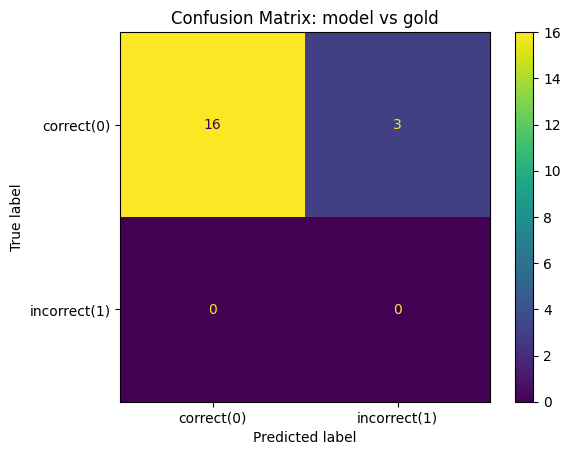

Saved results to /content/french_gector_results.csv

Examples where model changed the sentence (first 10):
GOLD: 0 | PRED: 1
ORIG: Nous partirons en randonnée demain matin.
CORR: Nous partons en randonnée demain matin.
------------------------------------------------------------
GOLD: 0 | PRED: 1
ORIG: Elle a acheté trois livres à la librairie du coin.
CORR: Elle a acheté trois livres à la librairie de coin.
------------------------------------------------------------
GOLD: 0 | PRED: 1
ORIG: Ils ont préparé un gâteau pour ton anniversaire.
CORR: Ils ont préparé un gâteau pour leur anniversaire.
------------------------------------------------------------


In [13]:
#@title Test pour voir si le modèle détecte bien les phrases comme correctes

!pip install -q transformers torch sentencepiece pandas openpyxl scikit-learn matplotlib tqdm

import os
import re
import math
import torch
import difflib
import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import matplotlib.pyplot as plt

# Configuration
MODEL_NAME = "PoloHuggingface/French_grammar_error_corrector"
DATA_PATH = "/content/file.xlsx"
BATCH_SIZE = 16
MAX_GEN_TOKENS = 256
IGNORE_PUNCT_ONLY_EDITS = True
SAVE_CSV = "/content/french_gector_results.csv"

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# load model & tokenizer
print("Loading model:", MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
model = model.to(device)
model.eval()
print("Model loaded.")

# load data and build gold labels
# Read Excel file; sentences in 2nd column (index 1), error counts in 3rd column (index 2)
df = pd.read_excel(DATA_PATH, header=1, engine="openpyxl")
if df.shape[1] < 3:
    raise ValueError(f"Expected at least 3 columns in {DATA_PATH} (found {df.shape[1]})")

sentences = df.iloc[:, 1].astype(str).fillna("").tolist()
error_counts = pd.to_numeric(df.iloc[:, 2], errors="coerce").fillna(0).astype(int).tolist()
gold_labels = np.array([1 if c > 0 else 0 for c in error_counts], dtype=int)

print(f"Loaded {len(sentences)} sentences. Positive (incorrect) examples: {gold_labels.sum()}")

# helper functions
_alnum_re = re.compile(r"\w+", flags=re.UNICODE)

def normalize_for_comparison(text):
    """
    Return list of word-like tokens (alphanumeric) to compare ignoring punctuation.
    Lowercases for robust comparison.
    """
    tokens = _alnum_re.findall(text.lower())
    return tokens

def is_punctuation_only_change(orig: str, corrected: str) -> bool:
    """
    Return True if the only changes between orig and corrected are punctuation tokens,
    i.e., the sequences of alphanumeric tokens are identical.
    """
    return normalize_for_comparison(orig) == normalize_for_comparison(corrected)

def model_made_significant_change(orig: str, corrected: str, ignore_punct_only=True) -> bool:
    """
    Decide whether the model actually changed the sentence in a way we consider grammatical.
    If ignore_punct_only is True, changes that only affect punctuation are ignored.
    """
    # Quick exact match
    if orig.strip() == corrected.strip():
        return False
    if ignore_punct_only and is_punctuation_only_change(orig, corrected):
        return False
    # Otherwise consider as a change (could be grammar, spelling, etc.)
    return True

# cell 5: batched inference
def generate_corrections(sent_list, batch_size=BATCH_SIZE, max_length=MAX_GEN_TOKENS, device=device):
    """
    Run the seq2seq model in batches and return decoded strings (corrected outputs).
    """
    corrected = []
    n = len(sent_list)
    for i in tqdm(range(0, n, batch_size), desc="Generating"):
        batch = sent_list[i:i+batch_size]
        # Tokenize with padding (left pad not required for seq2seq, but use padding=True)
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512)
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)

        with torch.no_grad():
            # Use beam search for slightly better corrections; adjust num_beams if desired
            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=max_length,
                num_beams=4,
                early_stopping=True,
                no_repeat_ngram_size=3
            )
        # decode each output
        decoded = [tokenizer.decode(out, skip_special_tokens=True, clean_up_tokenization_spaces=True) for out in outputs]
        corrected.extend(decoded)
    return corrected

corrected_outputs = generate_corrections(sentences, batch_size=BATCH_SIZE)

pred_labels = np.zeros(len(sentences), dtype=int)
for i, (orig, corr) in enumerate(zip(sentences, corrected_outputs)):
    changed = model_made_significant_change(orig, corr, ignore_punct_only=IGNORE_PUNCT_ONLY_EDITS)
    pred_labels[i] = 1 if changed else 0

print("Predicted incorrect (1) count:", int(pred_labels.sum()))

print("\nClassification report (all labels):")
print(classification_report(gold_labels, pred_labels, digits=4, zero_division=0))

# Focused positive-class metrics
p, r, f1, _ = precision_recall_fscore_support(gold_labels, pred_labels, pos_label=1, average='binary', zero_division=0)
print(f"Positive class (incorrect=1): Precision={p:.4f} Recall={r:.4f} F1={f1:.4f}")

# Confusion matrix plot
cm = confusion_matrix(gold_labels, pred_labels, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["correct(0)","incorrect(1)"])
disp.plot()
plt.title("Confusion Matrix: model vs gold")
plt.show()

out_df = pd.DataFrame({
    "sentence": sentences,
    "gold_label": gold_labels,
    "pred_label": pred_labels,
    "corrected_output": corrected_outputs
})
out_df.to_csv(SAVE_CSV, index=False, encoding="utf-8")
print(f"Saved results to {SAVE_CSV}")

print("\nExamples where model changed the sentence (first 10):")
cnt = 0
for orig, corr, g, p in zip(sentences, corrected_outputs, gold_labels, pred_labels):
    if p == 1:
        print("GOLD:", g, "| PRED:", p)
        print("ORIG:", orig)
        print("CORR:", corr)
        print("-" * 60)
        cnt += 1
        if cnt >= 10:
            break

### Conclusion : Ce modèle de correction grammaticale est très aggressif : il détecte très très facilement une phrase comme incorrecte.